In [1]:
from sentence_transformers import SentenceTransformer
from pathlib import Path
import pandas as pd

model = SentenceTransformer('dunzhang/stella_en_400M_v5', trust_remote_code=True)

Some weights of the model checkpoint at dunzhang/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
vertebrate_epigenomes = Path("../vertebrate_epigenomes")
bed_data = pd.read_parquet( vertebrate_epigenomes / "vertebrate_epigenomes_filt.parquet")
tissues = bed_data['tissue'].fillna('None').astype("category").cat.remove_unused_categories()
embedding = model.encode(tissues) # length 1024
embed_df = pd.DataFrame(embedding)
embed_df.index = tissues
embed_df.to_parquet( vertebrate_epigenomes / "tissue_embedding.parquet")

In [33]:
# embed_df = pd.read_parquet(vertebrate_epigenomes / "tissue_embedding.parquet")

# Species embedding

In [42]:
import networkx as nx
import numpy as np
from Bio import Phylo
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

for g in bed_data.species.cat.categories.tolist():
    print(g) # then got tree.nwk from timetree.org

bos_taurus
capra_hircus
danio_rerio
gallus_gallus
homo_sapiens
macaca_mulatta
mus_musculus
oryctolagus_cuniculus
ovis_aries
rattus_norvegicus
sus_scrofa
xenopus_tropicalis


In [ ]:
# Load the Newick file
tree = Phylo.read(vertebrate_epigenomes / "tree.nwk", "newick")

# Create a NetworkX graph from the parsed tree
G = nx.Graph()

# Counter to assign unique names to unnamed internal nodes
internal_node_counter = 1

# Function to recursively add nodes and edges from the Biopython tree
def add_edges(clade, parent=None):
    global internal_node_counter
    # Assign a name to unnamed internal nodes
    if clade.name is None:
        clade.name = f"internal_{internal_node_counter}"
        internal_node_counter += 1
    if parent is not None:
        G.add_edge(parent.name, clade.name, weight=clade.branch_length)
    for child in clade.clades:
        add_edges(child, clade)

# Initialize the graph construction
root = tree.root
add_edges(root)

# Get all the leaves (species)
leaves = [leaf.name for leaf in root.get_terminals()]

# Initialize the covariance matrix
num_leaves = len(leaves)
cov_matrix = np.zeros((num_leaves, num_leaves))

def find_mrca(leaf1, leaf2):
    path1 = nx.shortest_path(G, source=root.name, target=leaf1, weight='weight')
    path2 = nx.shortest_path(G, source=root.name, target=leaf2, weight='weight')

    # Iterate over the paths and find the deepest common node
    mrca = None
    for ancestor1, ancestor2 in zip(path1, path2):
        if ancestor1 == ancestor2:
            mrca = ancestor1
        else:
            break
    return mrca

# Compute distances between leaves and MRCAs
for i, leaf1 in enumerate(leaves):
    for j, leaf2 in enumerate(leaves):
        if i == j:
            # Variance (diagonal): distance from root to the leaf
            cov_matrix[i, j] = nx.shortest_path_length(G, source=root.name, target=leaf1, weight='weight')
        else:
            mrca = find_mrca(leaf1, leaf2)
            cov_matrix[i, j] = nx.shortest_path_length(G, source=root.name, target=mrca, weight='weight')

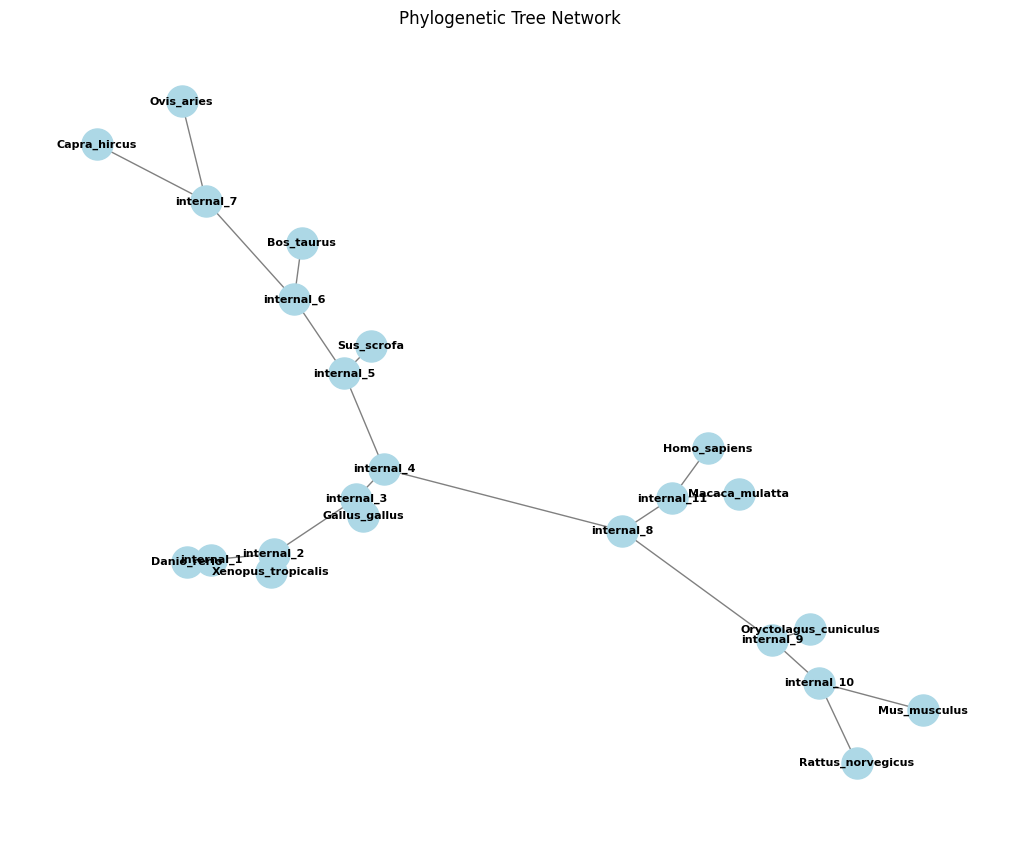

In [70]:

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Use a spring layout for a clear visual
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, font_weight='bold', node_color='lightblue', edge_color='gray')
plt.title("Phylogenetic Tree Network")
plt.show()


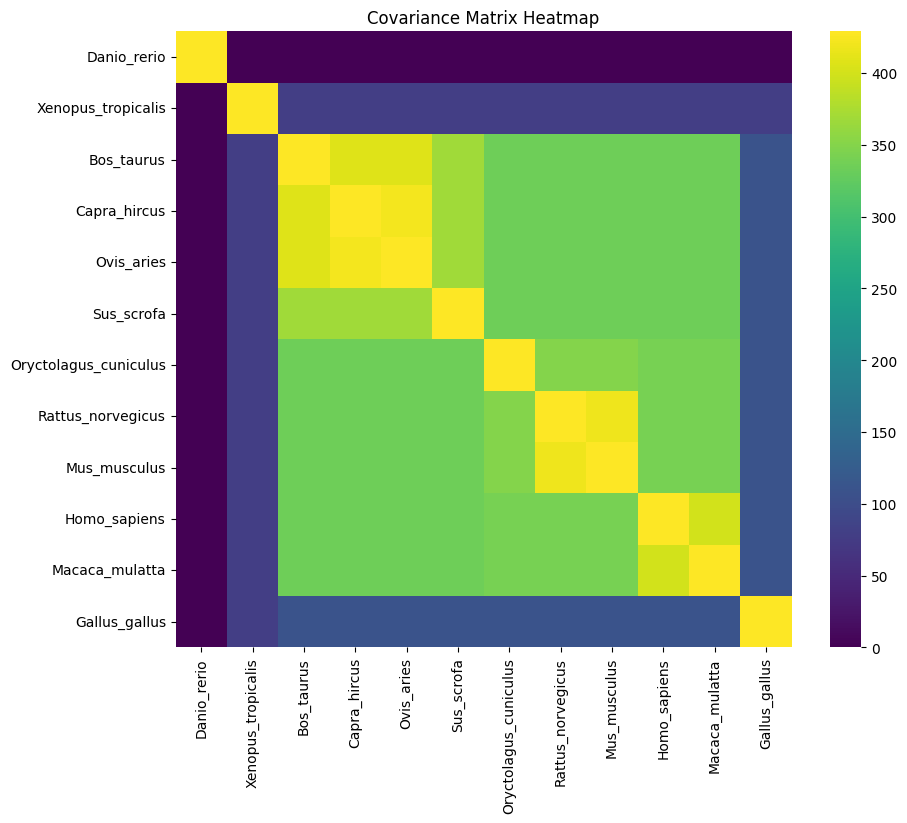

In [74]:
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, xticklabels=leaves, yticklabels=leaves, cmap='viridis', square=True)
plt.title('Covariance Matrix Heatmap')
plt.show()


In [87]:
# Mean vector (assuming mean of 0 for each species)
mean = np.zeros(num_leaves)

# Sample from the multivariate Gaussian
samples = np.random.multivariate_normal(mean, cov_matrix, size=1024) / np.sqrt(cov_matrix[0,0]) 

In [ ]:
species_embed = pd.DataFrame(samples.transpose())
species_embed.index = leaves
species_embed.index = species_embed.index.str.lower()
species_embed = species_embed.loc[ bed_data.species.cat.categories.tolist(), :]
species_embed

In [108]:
species_embed.to_parquet( vertebrate_epigenomes / "species_embed.parquet")

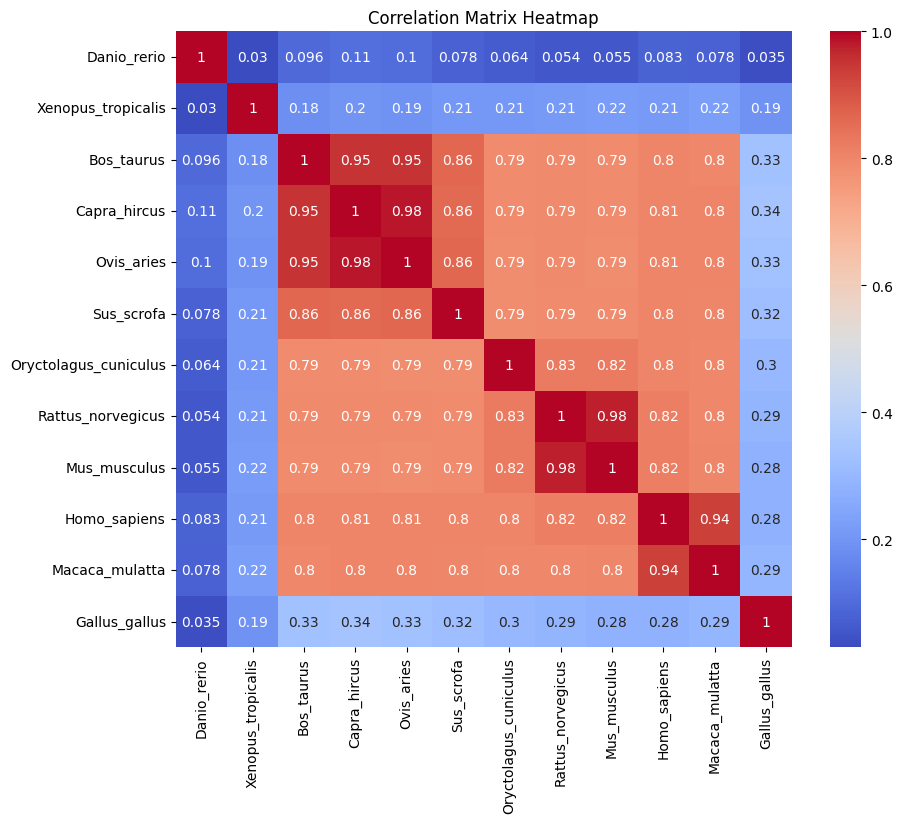

In [107]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, xticklabels=leaves, yticklabels=leaves, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()